## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
# Run only once, to solve the conflict with ROS
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [3]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib qt

# prepare object points
nx = 9 # TODO: enter the number of inside corners in x
ny = 6 # TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows() 

## And so on and so forth...

## 2. Apply a distortion correction to raw images.

In [4]:
# Calculate the distortion function
# Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## 3. Use color transforms, gradients, etc., to create a thresholded binary image. 

In [5]:
def gradients_threshold(grad_channel, ksize=15, x_thresh=(20, 255), y_thresh=(20, 255), 
                        mag_thresh=(30, 255), dir_thresh=(0.7, 1.3)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel_x = np.absolute(cv2.Sobel(grad_channel, cv2.CV_64F, 1, 0))
    abs_sobel_y = np.absolute(cv2.Sobel(grad_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel_x = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y/np.max(abs_sobel_y))
    # Create a copy and apply the threshold
    grad_x = np.zeros_like(scaled_sobel_x)
    grad_y = np.zeros_like(scaled_sobel_y)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_x[(scaled_sobel_x >= x_thresh[0]) & (scaled_sobel_x <= x_thresh[1])] = 1
    grad_y[(scaled_sobel_y >= y_thresh[0]) & (scaled_sobel_y <= y_thresh[1])] = 1
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(abs_sobel_x, abs_sobel_y)
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Combine the pixels where: 
    #     both the xx and yy gradients meet the threshold criteria
    #   or 
    #     the gradient magnitude and direction are both within their threshold values
    combined = np.zeros_like(grad_x)
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

In [6]:
# Gradients & Color threshold combined function
def combined_threshold(image, ksize=15, x_thresh=(20, 255), y_thresh=(20, 255), 
                       mag_thresh=(30, 255), dir_thresh=(0.7, 1.3), l_thresh=(120, 255), s_thresh=(170, 255)):
    # Choose a Sobel kernel size
    # Choose a larger odd number to smooth gradient measurements
    
    img = np.copy(image)
    # Convert to HLS color space and separate the L and S channel
    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # l_channel = hls[:,:,1]
    # s_channel = hls[:,:,2]
    l_channel = img[:,:,0] # R channel
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold s channel
    # s_binary = np.zeros_like(s_channel)
    # s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Select l channel to apply gradients thresholding
    l_grad_threshed = gradients_threshold(l_binary, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh)
    # Select s channel to apply gradients thresholding
    # s_grad_threshed = gradients_threshold(s_binary, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh)    
    
    # Stack each channel
    # combined_color = np.dstack(( s_grad_threshed, l_grad_threshed, np.zeros_like(l_grad_threshed))) * 255
    # combined = np.zeros_like(s_channel)
    # combined[(s_grad_threshed == 1) | (l_grad_threshed) == 1] = 1
    
    # plt.imshow(combined_color)
    
    # return combined
    return l_grad_threshed

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

## 5. Detect lane pixels and fit to find the lane boundary.

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        center_fitx = (left_fitx + right_fitx)/2
        center_fit = np.polyfit(ploty, center_fitx, 2)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='green')
    plt.plot(center_fitx, ploty, color='red')
    return out_img, left_fit, right_fit, center_fit


In [8]:
# Search around within the margin
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, center_margin):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Fit the center curverture
    center_fitx = (left_fitx + right_fitx)/2
    center_fit = np.polyfit(ploty, center_fitx, 2)
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) # *255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Generate a polygon to illustrate the safe driving area
    center_line_window1 = np.array([np.transpose(np.vstack([center_fitx-center_margin, ploty]))])
    center_line_window2 = np.array([np.flipud(np.transpose(np.vstack([center_fitx+center_margin, 
                              ploty])))])
    center_line_pts = np.hstack((center_line_window1, center_line_window2))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255, 0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 0, 255))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    cv2.fillPoly(window_img, np.int_([center_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.plot(center_fitx, ploty, color='red')
    ## End visualization steps ##
    
    return result, center_fit

## 5. b Another method

In [96]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids


In [97]:
# Testing
# Make a list of calibration images
# Step through the list and search for chessboard corners
for x in os.listdir("test_images/"):
    input_path = "test_images/" + x
    if os.path.isdir(input_path):
        continue
    
    # Read in each raw image
    raw_img = cv2.imread(input_path)
    
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # 2. Apply a distortion correction to raw images.
    undistorted = cal_undistort(raw_img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    ksize = 15
    x_thresh = (20, 255)
    y_thresh = (20, 255)
    mag_thresh = (30, 255)
    dir_thresh = (0.7, 1.3)
    l_thresh = (120, 255)
    s_thresh = (150, 255)
    combined_threshed = combined_threshold(undistorted, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh,
                                           l_thresh, s_thresh)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # Appoint source points and destination points
    imshape = (combined_threshed.shape[1], combined_threshed.shape[0])
    
    left = 200
    right = 1080
    top = 450
    bot = 700
    top_left = 0.46*imshape[0]
    src_left_top = (top_left, top)
    src_right_top = (imshape[0] - top_left, top)
    src_right_bot = (right, bot)
    src_left_bot = (left, bot)
    src = np.float32([[src_left_top, src_right_top, src_right_bot, src_left_bot]])
    new_left = 300 
    new_right = imshape[0] - new_left
    dst_left_top = (new_left, 0)
    dst_right_top = (new_right, 0)
    dst_right_bot = (new_right, imshape[1])
    dst_left_bot = (new_left, imshape[1])
    dst = np.float32([[dst_left_top, dst_right_top, dst_right_bot, dst_left_bot]])
    
    # 
    center_margin = 0.5*imshape[0] - new_left
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(combined_threshed, M, imshape)
    

    # 5. Detect lane pixels and fit to find the lane boundary.
    # out_img, left_fit, right_fit = fit_polynomial(binary_warped)
    # Note that in your project, you'll also want to feed in the previous fits
    # Polynomial fit values from the previous frame
    # Make sure to grab the actual values from the previous step in your project!
    # left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    # right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    # result = search_around_poly(binary_warped)
    
    
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # 7. Warp the detected lane boundaries back onto the original image.
    # 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=50)
    ax1.imshow(warped)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    ax2.imshow(output)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Show output image
    # cv2.imshow('output',output)
    # cv2.waitKey(100)
    
    # Outout the image to directory "/test_image_output"
    # output_path = "test_image_output/" + x
    # if os.path.isdir(output_path):
    #     continue
    # cv2.imwrite(output_path, output_image)
    
cv2.destroyAllWindows() 

NameError: name 'warped' is not defined

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [9]:
def measure_curvature_real(imshape, ym_per_pix, xm_per_pix, center_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    center_fit_cr = [center_fit[0]*xm_per_pix/ym_per_pix/ym_per_pix, 
                     center_fit[1]*xm_per_pix/ym_per_pix, center_fit[2]*xm_per_pix]
    
    # Define y-value where we want radius of curvature
    ploty = np.linspace(0, imshape[1]-1, num=imshape[1])# to cover same y-range as image
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    center_curverad = ((1 + (2*center_fit_cr[0]*y_eval*ym_per_pix + center_fit_cr[1])**2)**1.5) / np.absolute(2*center_fit_cr[0])
    lane_center = center_fit[0]*imshape[1]**2 + center_fit[1]*imshape[1] + center_fit[2]
    track_error = (0.5*imshape[0] - lane_center) * xm_per_pix *100 # in centimeter
    if(track_error >= 0):
        position_flag = "right"
    else:
        position_flag = "left"
    abs_track_error = np.abs(track_error)
    
    return center_curverad, abs_track_error, position_flag


## 7. Warp the detected lane boundaries back onto the original image.

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [27]:
# Testing
def img_pipeline(raw_img):
    
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # 2. Apply a distortion correction to raw images.
    # undistorted = cal_undistort(raw_img, objpoints, imgpoints)
    undistorted = raw_img
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    ksize = 15
    x_thresh = (20, 255)
    y_thresh = (20, 255)
    mag_thresh = (30, 255)
    dir_thresh = (0.7, 1.3)
    l_thresh = (170, 255)
    s_thresh = (120, 255)
    combined_threshed = combined_threshold(undistorted, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh, 
                                           l_thresh, s_thresh) 
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # Appoint source points and destination points
    imshape = (combined_threshed.shape[1], combined_threshed.shape[0])
    
    left = 0
    right = imshape[0]
    top = 0.52*imshape[1]
    bot = 1*imshape[1]
    top_left = 0.465*imshape[0]
    src_left_top = (top_left, top)
    src_right_top = (imshape[0] - top_left, top)
    src_right_bot = (right, bot)
    src_left_bot = (left, bot)
    src = np.float32([[src_left_top, src_right_top, src_right_bot, src_left_bot]])
    new_left = 0.3*imshape[0] 
    new_right = imshape[0] - new_left
    dst_left_top = (new_left, 0)
    dst_right_top = (new_right, 0)
    dst_right_bot = (new_right, imshape[1])
    dst_left_bot = (new_left, imshape[1])
    dst = np.float32([[dst_left_top, dst_right_top, dst_right_bot, dst_left_bot]])
    
    # 
    center_margin = 0.5*imshape[0] - new_left
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(combined_threshed, M, imshape) 
    

    # 5. Detect lane pixels and fit to find the lane boundary.
    out_img, left_fit, right_fit, center_fit = fit_polynomial(binary_warped)
    result, center_fit = search_around_poly(binary_warped, left_fit, right_fit, center_margin)
    
    # Note that in your project, you'll also want to feed in the previous fits
    # Polynomial fit values from the previous frame    
    # if ((left_fit is None) | (right_fit is None)):
    #     out_img, left_fit, right_fit = fit_polynomial(binary_warped)  
    # else :
    #     result = search_around_poly(binary_warped)

    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 50/imshape[1] # meters per pixel in y dimension
    xm_per_pix = 7/2/center_margin # meters per pixel in x dimension
    # Calculate the radius of curvature in meters for both lane lines
    center_curverad, abs_track_error, position_flag = measure_curvature_real(imshape, ym_per_pix, xm_per_pix, center_fit)
    
    # 7. Warp the detected lane boundaries back onto the original image.
    result_unwarped = cv2.warpPerspective(result, Minv, imshape)
    result_unwarped = cv2.cvtColor(result_unwarped, cv2.COLOR_BGR2RGB)
    output_image = cv2.addWeighted(raw_img, 1, result_unwarped, 1, 0)
    
    # 8. Output visual display of the lane boundaries 
    # and numerical estimation of lane curvature and vehicle position.
    precision = 1
    center_curverad = str(np.round(center_curverad, precision))
    abs_track_error = str(np.round(abs_track_error, precision))
    
    # Add text to the image
    text_1 = "Radius of Lane = " + center_curverad + "m"
    text_2 = "Vehicle is " + abs_track_error + "cm " + position_flag + " of center"
    cv2.putText(output_image, text_1, (int(0.7*imshape[0]), int(0.9*imshape[1])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(output_image, text_2, (int(0.7*imshape[0]), int(0.95*imshape[1])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=50)
    ax1.imshow(combined_threshed)
    ax2.set_title('Combined and Unwarped Image', fontsize=50)
    ax2.imshow(binary_warped)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=50)
    ax1.imshow(result)
    ax2.set_title('Combined and Unwarped Image', fontsize=50)
    ax2.imshow(output_image)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    return output_image
    # return output_image

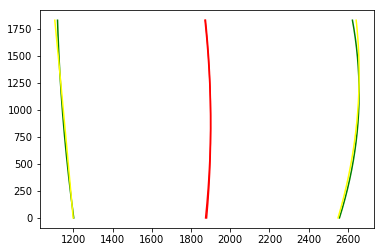

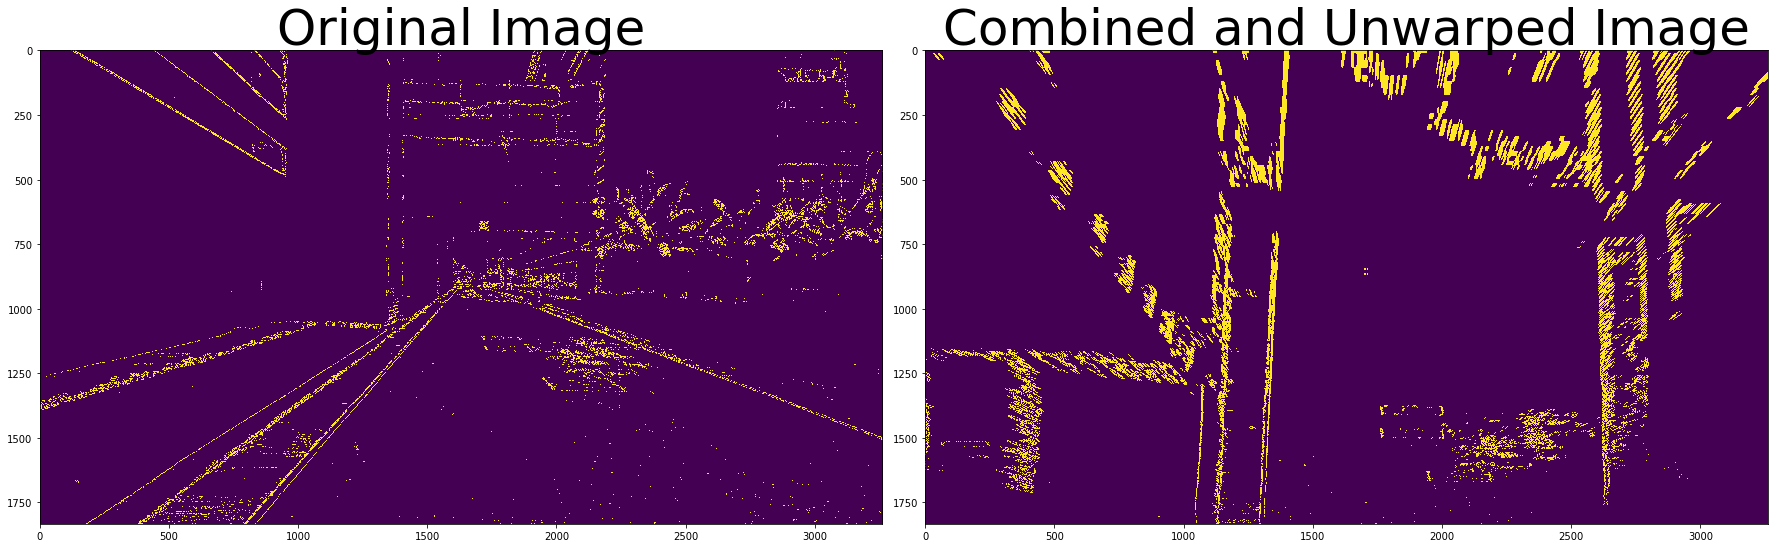

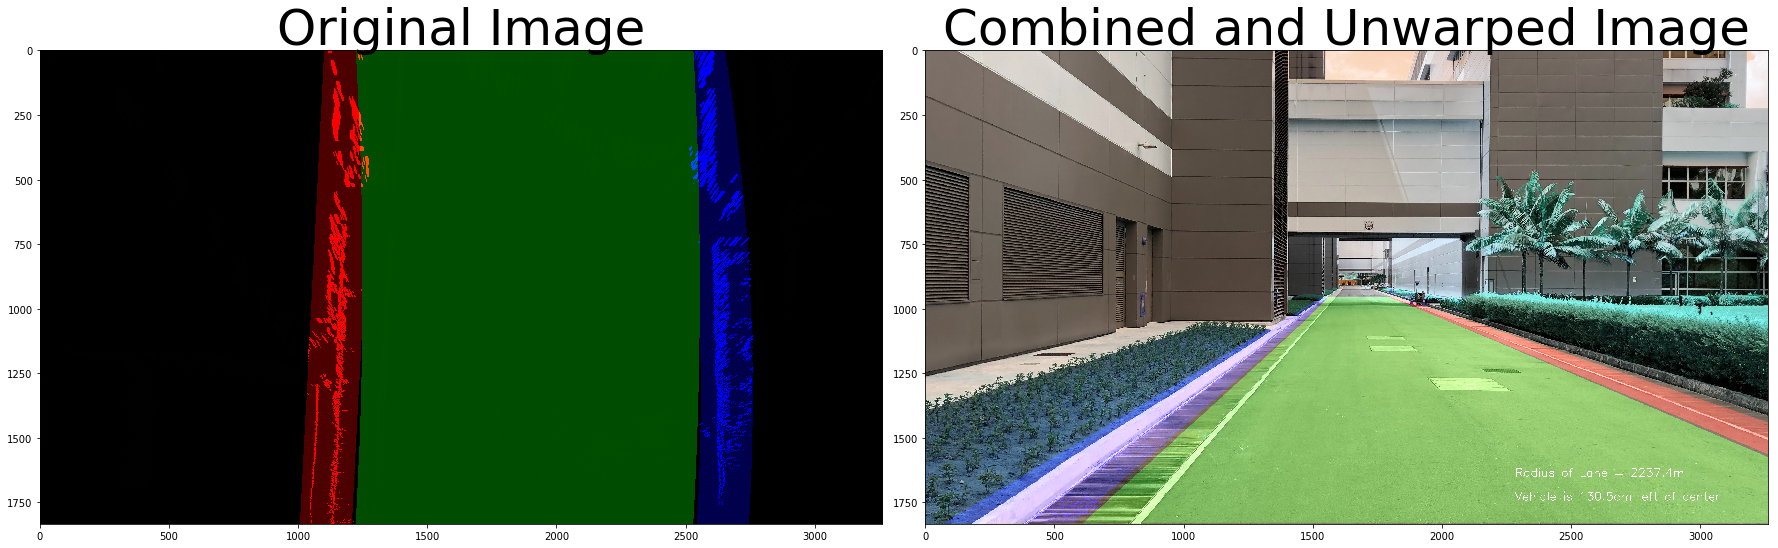

In [28]:
# Make a list of calibration images
# Step through the list and search for chessboard corners
for x in os.listdir("test_images/"):
    input_path = "test_images/" + x
    if os.path.isdir(input_path):
        continue
    
    # Read in each raw image
    raw_img = cv2.imread(input_path)    
    
    output_img = img_pipeline(raw_img)
    
    # Outout the image to directory "/test_image_output"
    output_path = "process/" + x
    # output_path = "test_images_output/" + x
    if os.path.isdir(output_path):
        continue
    cv2.imwrite(output_path, output_img)
 

# Runing on Videos